In [1]:
import sys
import pandas as pd
import numpy as np 
pd.set_option('display.max_columns', None)

data = pd.read_csv('/home/jack/data/omscs/6250 - bd4h/Project/BD4H-H2/submission 3/data/mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data

,icu_adm_flag,hosdeath_flag,gender,marital_status,ethnicity,insurance,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,admflag_last1yr,time2bg_24hr_flag,ed_medgp_antibiotic_hrgp,ed_medgp_antidote,ed_medgp_cardiovascular,ed_medgp_coagulation,ed_medgp_diabetes,ed_medgp_electrolytes,ed_medgp_gastrointestinal,ed_medgp_metabolic_and_endocrine,ed_medgp_multiple,ed_medgp_nervous_system,ed_medgp_others,ed_medgp_procedural_adjunct,ed_medgp_respiratory,ed_medgp_steroids,ed_medgp_symptomatic,ed_medgp_urology,ed_medgp_wound,ed_a_azithromycin,ed_a_cefepime,ed_a_ceftriaxone,ed_a_ceftriaxone_mini_bag_plus,ed_a_ciprofloxacin,ed_a_levofloxacin,ed_a_metronidazole_flagyl,ed_a_nitrofurantoin_monohy__macrobid,ed_a_others,ed_a_piperacillin_tazobactam_na,ed_a_vancomycin,age,charlson_comorbidity_index,edvital_temperature_min,edvital_temperature_max,edvital_temperature_median,edvital_heartrate_min,edvital_heartrate_max,edvital_heartrate_median,edvital_resprate_min,edvital_resprate_max,edvital_resprate_median,edvital_o2sat_min,edvital_o2sat_max,edvital_o2sat_median,edvital_sbp_min,edvital_sbp_max,edvital_sbp_median,edvital_dbp_min,edvital_dbp_max,edvital_dbp_median,fbc24hr_hematocrit_first,fbc24hr_hemoglobin_first,fbc24hr_mch_first,fbc24hr_mchc_first,fbc24hr_mcv_first,fbc24hr_platelet_first,fbc24hr_rbc_first,fbc24hr_rdw_first,fbc24hr_wbc_first,chem24hr_aniongap_first,chem24hr_bun_first,chem24hr_chloride_first,chem24hr_glucose_first
0,0,0,F,SINGLE,WHITE,Medicare,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,b_more1_lesse3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,93,5,98.3,99.3,98.80,80,82,81.0,16.0,16,16.0,89,98,95.0,158,164,159.0,83,102.0,94.0,38.4,12.8,32.4,33.2,98.0,154,3.93,13.3,8.4,19,19,102,77
1,0,0,F,SINGLE,HISPANIC/LATINO,Other,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,c_more3_lesse6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,40,2,98.7,99.0,98.85,89,124,94.0,18.0,19,18.0,98,99,98.0,107,124,119.0,61,76.0,71.0,28.0,9.2,28.3,32.6,87.0,414,3.30,13.8,13.1,13,10,103,286
2,0,1,F,WIDOWED,WHITE,Medicare,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,e_notgiven,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,85,6,95.2,97.0,96.10,78,87,82.0,18.0,26,22.0,94,99,96.0,66,102,82.0,31,43.0,37.0,29.7,9.7,29.1,32.8,89.0,355,3.24,14.4,12.0,11,11,100,79
3,0,1,F,MARRIED,WHITE,Medicare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,a_lesse1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,85,10,98.0,98.0,98.00,101,108,103.0,17.0,22,20.0,95,100,97.5,76,105,84.0,45,67.0,55.0,28.8,8.4,27.5,29.3,93.0,454,3.11,24.6,16.3,18,46,112,122
4,0,0,M,WIDOWED,WHITE,Medicare,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,e_notgiven,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,5,97.6,98.4,97.60,76,86,79.0,16.0,18,16.0,94,98,95.0,120,149,132.5,55,84.0,66.5,44.5,14.5,29.5,32.6,90.0,187,4.89,16.0,7.5,18,21,99,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7685,0,0,M,WIDOWED,BLACK/AFRICAN AMERICAN,Medicare,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,b_more1_lesse3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,66,10,97.9,98.1,98.10,77,86,81.0,16.0,20,16.0,97,100,99.0,99,110,106.0,63,85.0,71.0,35.2,11.4,28.0,32.3,87.0,167,4.05,16.6,3.7,22,53,91,112
7686,0,0,F,WIDOWED,WHITE,Medicare,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,d_more6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,90,6,97.7,98.4,97.95,78,93,81.5,15.0,20,17.0,98,99,99.0,122,140,130.0,49,87.0,65.5,32.0,11.4,29.6,35.7,83.0,271,3.86,13.1,8.8,15,18,96,98
768

In [5]:
data = pd.concat([data, pd.get_dummies(data['gender'], prefix='gender')], axis=1)
print(f"gender categories: {pd.get_dummies(data['gender'], prefix='gender').shape[1]}")
data = data.drop(['gender'], axis=1)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
print(f"marital status categories: {pd.get_dummies(data['marital_status'], prefix='marital_status').shape[1]}")
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
print(f"ethnicity categories: {pd.get_dummies(data['ethnicity'], prefix='ethnicity').shape[1]}")
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
print(f"insurance categories: {pd.get_dummies(data['insurance'], prefix='insurance').shape[1]}")
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
print(f"antibiotic categories: {pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic').shape[1]}")
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

print(f"null val count: {data.isna().to_numpy().sum()}")

gender categories: 2
marital status categories: 5
ethnicity categories: 5
insurance categories: 3
antibiotic categories: 5
null val count: 0


In [6]:
print(f"icu admission pct: {(len(data[(data['icu_adm_flag'] > 0)]) / len(data)) * 100}%")
print(f"mortality pct: {(len(data[(data['hosdeath_flag'] > 0)]) / len(data)) * 100}%")

icu admission pct: 26.879063719115738%
mortality pct: 6.957087126137841%


In [7]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['icu_adm_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [8]:
X_train.shape

(5383, 99)

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import StratifiedKFold


clf = RandomForestClassifier(n_estimators=140, max_depth=5, random_state=seed)

skf = StratifiedKFold(n_splits=5, random_state=888, shuffle=True)

calibrated_clf = CalibratedClassifierCV(clf, cv=skf, method='isotonic')
calibrated_clf.fit(X_train, y_train)

# calibrated_clf.calibrated_classifiers_

CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=888, shuffle=True),
                       estimator=RandomForestClassifier(max_depth=5,
                                                        n_estimators=140,
                                                        random_state=7),
                       method='isotonic')

In [ ]:
import shap
from scipy.special import logit

shap_values_list = []
shap_expected_values_list = []
for calibrated_classifier in calibrated_clf.calibrated_classifiers_:
    explainer = shap.TreeExplainer(
        calibrated_classifier.estimator,
        feature_perturbation = "tree_path_dependent")
    shap_values = explainer.shap_values(X_train)
    expected_value = explainer.expected_value
    if len(shap_values) == 2:
        shap_values = logit(shap_values[1]+expected_value[1]) - logit(expected_value[1])
        expected_value = logit(expected_value[1])
    shap_values_list.append(shap_values)
    shap_expected_values_list.append(expected_value)

shap_values = np.array(shap_values_list).sum(axis=0) / len(shap_values_list)
expected_value = np.mean(shap_expected_values_list)

In [ ]:
variables = X_train.columns[
  np.argsort(np.abs(shap_values).mean(0))
][::-1][:10].values

In [ ]:
column_label = 'time2bg_24hr_flag'
column_index = X_train.columns.get_indexer([column_label])[0]
column_shap_values = shap_values[:, column_index]
column_values = X_train[column_label].values

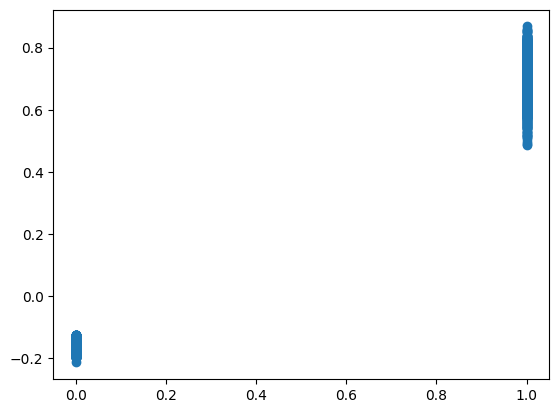

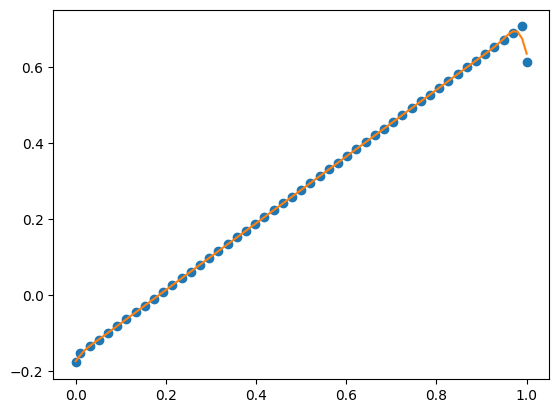

In [ ]:
from csaps import csaps
import matplotlib.pyplot as plt


xs_array = []
ys_array = []

def find_breakpoints(column_label, moving_average_size=50,
                      spline_sample_size=100, plot_graphs=False):
    column_index = X_train.columns.get_indexer([column_label])[0]
    column_shap_values = shap_values[:, column_index]
    column_values = X_train[column_label].values

    if plot_graphs:
        plt.scatter(X_train[column_label], shap_values[:, column_index])
        plt.show()

    # sort according to column values
    sorted_index = np.argsort(column_values)
    column_shap_values_sorted = column_shap_values[sorted_index]
    column_values_sorted = column_values[sorted_index]

    # Start of moving average algorithm
    xs = np.linspace(
        column_values_sorted[0],
        column_values_sorted[-1],
        moving_average_size)
    x = []
    y = []

    index = 0
    for xi in xs:
        if index == 0:
            start = xi
            x.append(xi)
            y.append(column_shap_values_sorted[0])
        else:
            if index == moving_average_size - 1:
                range_index = np.where(
                    (column_values_sorted >= start) &
                    (column_values_sorted <= xi))
            else:
                range_index = np.where(
                    (column_values_sorted >= start) &
                    (column_values_sorted < xi))
            x_mean = (start + xi)/2

            if len(range_index[0]) > 0:
                y_mean = np.mean(column_shap_values_sorted[range_index])
            else:
                y_mean = np.nan

            x.append(x_mean)
            y.append(y_mean)
            start = xi

        if index == moving_average_size - 1:
            x.append(xi)
            y.append(column_shap_values_sorted[-1])
        index += 1

    y = np.array(y)

    # Interpolate nan values
    nans, mask = np.isnan(y), lambda z: z.nonzero()[0]
    y[nans]= np.interp(mask(nans), mask(~nans), y[~nans])

    # Find the best fitting spline
    xs = np.linspace(x[0], x[-1], spline_sample_size)
    smoothing_result = csaps(x, y, xs)
    ys = smoothing_result.values

    xs_array.append(xs)
    ys_array.append(ys)

    if plot_graphs:
        plt.plot(x, y, 'o', xs, ys, '-')
        plt.show()

    # Find ranges with different risks with respect to baseline
    index = 0
    ys_sign = np.sign(ys)

    range_arr = []
    merge_flag = 0

    for xi in xs:
        if index == 0 or index == (len(ys) - 1):
            range_arr.append(xi)
            start = xi
        else:
            if ys_sign[index] != ys_sign[index-1]:
                x1, y1 = xs[index-1], ys[index-1]
                x2, y2 = xs[index], ys[index]

                gradient = (y2-y1)/(x2-x1)
                intercept = y1 - gradient * x1
                x_intercept = - intercept / gradient

                end = x_intercept
                range_index = np.where((column_values_sorted >= start) &
                                        (column_values_sorted <= end))

                if len(range_index[0]) != 0:
                    range_arr.append(end)
                    start = end
        index += 1


    # Calculate risks and odds ratio within each range
    # column_actual_shap_values_sorted = np.add(
    #     column_shap_values_sorted, self.expected_value)

    shap_array = []
    shap_sd_array = []
    shap_n_array = []
    # p_array = []
    # or_array = []

    for index in range(len(range_arr)):
        if index != 0:
            range_index =  np.where((column_values_sorted >= range_arr[index-1]) &
                                    (column_values_sorted <= range_arr[index]))

            # mean_shap_value = np.mean(column_actual_shap_values_sorted[range_index])
            shap_array.append(np.mean(column_shap_values_sorted[range_index]))
            shap_sd_array.append(np.std(column_shap_values_sorted[range_index]))
            shap_n_array.append(len(column_shap_values_sorted[range_index]))
            # p = expit(mean_shap_value)
            # p_array.append(p)
            # or_array.append(p/(1-p))

    return range_arr, shap_array, shap_sd_array, shap_n_array#, p_array, or_array


breakpoints, shap_array, shap_sd_array, shap_n_array = find_breakpoints("time2bg_24hr_flag", plot_graphs=True)

In [ ]:
shap_array

[-0.1530402823092222, 0.7062846531840201]